# Session 3:  Parallel Processing with MsPASS
## *Gary L. Pavlis*
## *Ian Wang*

## Overview

This notebook is a hands on exercise that students will run during the third session of this class.   The first two session provided background needed to utilize MsPASS effectively.   The material there is useful to any seismologist.   Although parallel processing of huge data sets is a primary purpose of MsPASS, for research computing it is worth emphasizing a couple of key points you will here us preach in the presentation that goes with this notebooK

- If your computation is feasible with serial processing, you may not need to introduce the extra complexity involved in parallel processing.
- Every parallel processing workflow should always be prototyped as a serial job first because errors in parallel jobs can be much harder to unravel.
- Your mantra in developing a parallel work flow should be this old saying in computing:  "Make it work before you make it fast".   Tuning a workflow for performance can be time consuming.  Whether or not the effort required is justified depends upon how much data you need to handle and how likely it is you will need to run it again. 

The learning objective of this tutorial is these elements of developing a parallel workflow in MsPASS:
1.  Guidance on how to develop the python code that defines your workflow to run in parallel.   That development normally should be done on a small subset of the data as a "serial job" before transforming the task to a parallel job.
2.  How to translate your serial prototype into a parallel job.

MsPASS supports two different "schedulers" for handling parallel processing:  (1) dask, and (2) spark (technically pyspark).  We will only use the default scheduler for MsPASS, dask, for this class for a number of reasons.    

TODO:   This next paragraph will need to be changed once the new Jupyter Hub setup is finalized.

This notebook is best run with access to the dask diagnostic port (default is 8787).  If you are running a cluster you are likely already set up to access 8787.   If you are running on desktop/laptop with docker you should make sure you start the container with some variant of this run line:
```
docker run -p 8888:8888 -p 8787:8787 --mount src=`pwd`,target=/home,type=bind mspass/mspass
```

First, the usual connection to the database.

above needs:
- overview of content
- a statement about using parallel stuff only for huge task - don't go here i fyou don't have to.
- limit to dask

Somewhere in this notebook need:
- step back to coordinate ransformation stuff leaning on tutorial on Seismogram uses

In [1]:
from mspasspy.db.database import Database
import mspasspy.client as msc
mspass_client = msc.Client(database_name='Earthscope2024')
db = mspass_client.get_database()

Then doing a series of imports needed to support the workflow.  Note common practice is that during development of a workflow in a notebook it is a good idea to keep most imports at the top like this, add to the code as needed, and after each change push the run button.

In [2]:
from mspasspy.io.distributed import read_distributed_data,write_distributed_data
from mspasspy.algorithms.window import WindowData,scale
from mspasspy.algorithms.basic import ator
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.ccore.utility import ErrorSeverity
from mspasspy.db.normalize import ObjectIdMatcher,normalize
from mspasspy.algorithms.signals import filter
import matplotlib.pyplot as plt
from mspasspy.graphics import SeismicPlotter
from obspy import UTCDateTime
import time

## Serial Prototype
### Seismogram Processing
A key concept to understand about the normal model for parallel processing with MsPASS is that most workflows of interest can be prototyped as a top-level loop over data.   i.e. in pseudocode the processing boils down to `foreach datum do something` where the `something` is a chain of processing algorithms.   That type of data handling is commonly called a "pipeline" and is universally recognized as "embarrassingly parallel".   That means simply that parallel processing can nearly always perform well and scale close to optimal values based on __[Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law)__.

Because most processing workflows can be reduced to a pipeline, we have found that it is always wise to prototype your workflow code with a "serial" version that defines a loop over data. That said, let's review what we did previously in session 1 to build what might be called a "preprocessed" data set.  

- We ran a basic waveform segmentation sequence:   detrend, filter, define phase metadata, and window data around times related to a phase.  In our case, we computed the P phase time from a standard earth model and windowed data around a time relative to that computed time.   The results of that processing where stored to the default "gridfs" storage in the "wf_TimeSeries" collection.
- We ran the  [bundle_seed_data](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.bundle.bundle_seed_data) function to more-or-less convert the content of the entire "wf_TimeSeries" collection to a parallel data set of `Seismogram` objects that we stored in "wf_Seismogram".

To make that clear, let's plot the first `Seismogram` objects created in the first sequence stored in "wf_TimeSeries":

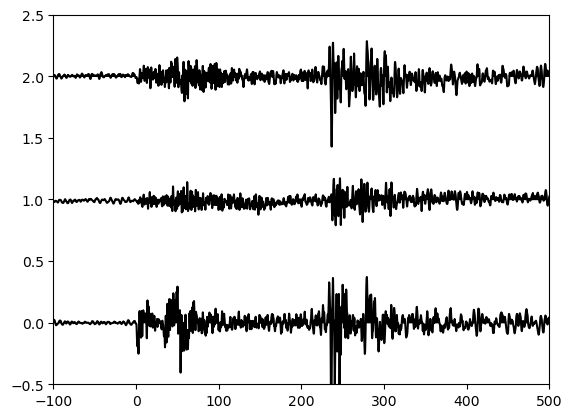

In [3]:
# query is necessary because not all Seismogram data have Ptime set.  This guarantees we find the first one that does have it set
doc = db.wf_Seismogram.find_one({'Ptime' : {'$exists' : 1}})
d = db.read_data(doc,collection='wf_Seismogram')
# shift data so 0 is approximate P wave arrival time
Ptime = d['Ptime']
d = ator(d,Ptime)
plotter = SeismicPlotter(normalize=True)
plotter.change_style('wtva')
plotter.plot(d)

Noting the components plotted from the top down are BHE, BHN, and BHZ.   

An important side issue here is that a unique feature MsPASS compared to any other framework we know if is that we handle three-component data in the unified object we call a `Seismogram`.   We address this issue ad nauseum in the user manual.   But there are several features of `Seismogram` that are relevant to this tutorial:
1.  A `Seismogram` object keeps track of the orientation of the components in space relative to the local geographic reference frame at the station.  We will dig into this a bit in a moment.
2.  A `Seismogram` unifies the generic concept of coordinate transformations to allow simple rotations to coordinates like RTZ to a general coordinate transformation using the `transform` method of `Seismogram` or the [transform function wrapper](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.basic.transform) wrapper function used for parallel processing constructs like those we will use below.  In this tutorial we will be using a particularly useful, but relatively complicated function useful for P wave receiver function processing, called [free_surface_transformation](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.basic.free_surface_transformation).
3.  Unless you apply a singular transformation, the data can always be restored to the standard coordinate reference frame of x1=EW, x2=NS, and x3=Z with the `rotate_to_standard` method of the data object or the [rotate_to_standard wrapper function](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.basic.rotate_to_standard).

To make this clearer we will explore that a bit before proceeding.  A more in depth version of this material can be found [here](https://github.com/mspass-team/mspass_tutorial/blob/master/notebooks/Three-ComponentBasics.ipynb).

In [4]:
print(d.cardinal())
print(d.tmatrix)

False
[[0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [2.64845403e-14 1.00000000e+00 2.64845403e-14]
 [1.00000000e+00 0.00000000e+00 2.64845403e-14]]


In [5]:
from mspasspy.algorithms.basic import rotate_to_standard
d = rotate_to_standard(d)
print(d.cardinal())
print(d.tmatrix)

True
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Note:
- The `cardinal` method returns True after calling `rotate_to_standard`.
- The form of the transformation matrix should tell you why that is so.  The transformation matrix of a `Seismogram` object is fundamental as it give the coordinate reference frame for the current state of the data.   As this shows we went from nonstandard to standard (ENZ) coordinates.

MsPASS has a relatively complete set of coordinate transformation operators form simple rotation around Z to the most sophisticated coordinate transformation for P wave data  commonly called the "free surface transformation". The theory for the matrix transformation is in Brian Kennett's (1983) book on layered media theory. We will apply that operator to these data as it is arguably the best way to prepare teleseismic P wave data for receiver function deconvolution.   A more complete tutorial on the transformation operators available for `Seismogram` objects can be found [here](https://github.com/mspass-team/mspass_tutorial/blob/master/notebooks/Three-ComponentBasics.ipynb).

The next code box defines a function that we can apply to `Seismogram` objects to apply the free surface transformation.  Note the operator requires us to know the ray parameter for the P wave being analyzed.  We set that when we created the preprocessed data during session 1 of this class.

In [6]:
import math
from mspasspy.ccore.seismic import SlownessVector
from mspasspy.algorithms.basic import free_surface_transformation
from mspasspy.ccore.utility import ErrorSeverity

def apply_FST(d,rayp_key="rayp_P",seaz_key='seaz',vp0=6.0,vs0=3.5):
    """
    Apply free surface transformation operator of Kennett (1983) to an input `Seismogram` 
    object.   Assumes ray parameter and azimuth data are stored as Metadata in the 
    input datum.  If the ray parameter or azimuth key are not defined an error 
    message will be posted and the datum will be killed before returning.  
    :param d:  datum to process
    :type d:  Seismogram
    :param rayp_key:   key to use to extract ray parameter to use to compute the 
    free surface transformation operator.  Note function assumes the ray parameter is
    spherical coordinate form:  R sin(theta)/V.   Default is "rayp_P".
    :param seaz_key:   key to use to extract station to event azimuth. Default is "seaz".
    :param vp0:  surface P wave velocity (km/s) to use for free surface transformation 
    :param vs0:  surface S wave velocity (km/s) to use for free surface transformation.
    """
    if d.is_defined(rayp_key) and d.is_defined(seaz_key):
        rayp = d[rayp_key]
        seaz = d[seaz_key]
        # Some basic seismology here.  rayp is the spherical earth ray parameter
        # R sin(theta)/v.  Free surface transformation needs apparent velocity 
        # at Earth's surface which is sin(theta)/v when R=Re.   Hence the following
        # simple convertion to get apparent slowness at surface  sin(theta)/v
        Re=6378.1
        umag = rayp/Re   # magnitude of slowness vector
        # seaz is back azimuth - slowness vector points in direction of propagation
        # with is 180 degrees away from back azimuth
        az = seaz + 180.0
        # component slowness vector components in local coordinates
        ux = umag * math.sin(az)
        uy = umag * math.cos(az)
        # FST implementation requires this special class called a Slowness Vector
        u = SlownessVector(ux,uy)
        d = free_surface_transformation(d,u,vp0,vs0)
    else:
        d.kill()
        message = "one of required attributes rayp_P or seaz were not defined for this datum"
        d.elog.log_error("apply_FST",message,ErrorSeverity.Invalid)
        
    return d

Let's quickly verify that works and does what we expect.

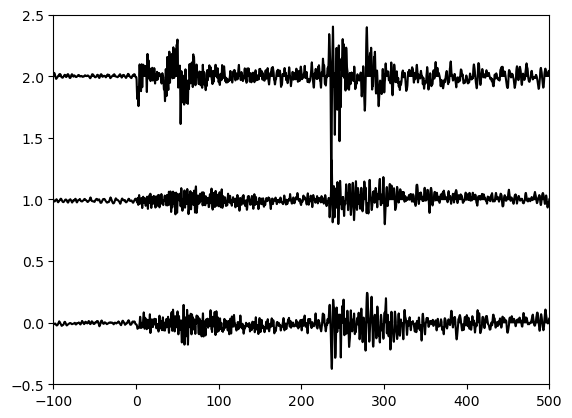

In [7]:
# testing only to prepare this notebook - delete
d2=apply_FST(d)
plotter.plot(d2)
# plot is from bottom up SH, SV, P

As the comment says the plot from the bottom up is SH, SV, P.   Note that that means component 0 is SH, 1 is SV, and 2 is P (longitudinal).

## In Class Exercise 1:
Print the transformation matrix input d and the output d2 of the ApplyFST function.  Paste them into the markdown box for question 1 of Homework2 and answer the question posed there.     

In [8]:
# Add code here for this exercise - the following I'll give you as it can help you understand the issues
print(d['seaz'])

265.2965605492624


### Signal-to-noise estimation
In receiver function processing a critical issue is automatic editing to remove data that will never deconvolve.   That generally involves computing a set of metrics that define signal quality.   One of the most basic of those is "signal-to-noise ratio".  Unfortunately, with modern broadband seismic data the definition of signal-to-noise ratio is not simple.   That is particularly true with receiver function processing where we will be using the longitudinal(L) component after the free surface transformation as the "wavelet" for deconvolving the SV and SH components.   In most data the noise properties of SV and SH are drastically different than P/L.   In our experience no single metric can provide a universally useful measure of signal reliability.  As a result, we developed a set of function in MsPASS found in the `mspasspy.algorithms.snr` module.  For this processing we will be using a top-level function that is kind of a "do-all" function.  i.e. it computes a long list of snr metrics it computes from `Seismogram` data.   More details are given in the [User Manual page](http://www.mspass.org/user_manual/signal_to_noise.html) on this topic and in the docstring for the function we will used called [broadband_snr_QC](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.snr.broadband_snr_QC).  We will also give describe a few more details during the class session.  

With that brief overview, it will be helpful to run this function on the datum, *d2*, we just just created to see what it computes:

In [9]:
from mspasspy.algorithms.snr import broadband_snr_QC
from mspasspy.ccore.algorithms.basic import TimeWindow
noise_window=TimeWindow(-90.0,-5.0)
# test on one to use in the prototype workflow
d3 = broadband_snr_QC(d2,
                      component=2,
                      use_measured_arrival_time=True,
                      measured_arrival_time_key="Ptime",
                      noise_window=noise_window,
                      kill_null_signals=True,
                     )

In [10]:
from bson import json_util
doc=d3['Parrival']
print(json_util.dumps(doc,indent=2))

{
  "low_f_band_edge": 0.02399520095980804,
  "high_f_band_edge": 2.0,
  "low_f_band_edge_snr": 33.87577839080319,
  "high_f_band_edge_snr": 25.395835787120134,
  "spectrum_frequency_range": 20.0,
  "bandwidth_fraction": 0.0988002399520096,
  "bandwidth": 38.41811208328048,
  "q1_4_snr": 25.898747261485372,
  "mean_snr": 68.22184377941426,
  "maximum_snr": 190.38577074624513,
  "q3_4_snr": 106.8235410275945,
  "stats_are_valid": true,
  "minimum_snr": 4.18956730254738,
  "median_snr": 62.455399007729014,
  "snr_filtered_envelope_peak": 41.454067724905926,
  "snr_filtered_rms": 9.838248368462786,
  "snr_filtered_peak": 29.976726760728905,
  "snr_filtered_mad": 6.598959667187201,
  "snr_filtered_perc": 25.39429895146204,
  "snr_perc": 95.0,
  "phase": "P",
  "snr_arrival_time": 1323839889.7769792,
  "snr_signal_window_start": 1323839884.7769792,
  "snr_signal_window_end": 1323840009.7769792,
  "snr_noise_window_start": 1323839799.7769792,
  "snr_noise_window_end": 1323839884.7769792,
  "

Note the functions output is bundled into a dictionary container and loaded to d2 with the key "Parrival".  In MongoDB jargon, "Parrival" defines a "subdocument".   

There are a lot of things posted there, but it might be useful to point out they are the outputs of two algorithms.
1.  The first stage of this computation computes the power spectrum of a signal window and a noise window.   It then searches from the high and low frequency end to define the attributes `low_f_band_edge` and `high_f_band_edge` where snr exceeds a default threshold we used here.   Metrics like `maximum_snr` are the largest snr found within that frequency range.
2.  From the estimated bandwidth computed in stage 1 the algorithm filters the data with a bandpass filter between `low_f_band_edge` and `high_f_band_edge`.  An envelope function is then applied to that signal and set of amplitude metrics with the "filtered" name (e.g. `snr_filtered_rms`) are computed in the signal and noise time windows.

The details of the above you can absorb later.  The KEY POINT you should get here is that `broadband_snr_QC` does a significant amount of computation and is a prime candidate for parallelization.  To see that, let's do a prototype run of the processing we will do here in a serial loop.

In [11]:
#trial serial run
query={'Ptime' : {'$exists' : 1},'data_tag' : 'serial_preprocessed'}
N=100
cursor=db.wf_Seismogram.find(query).limit(N)
t0 = time.time()
for doc in cursor:
    d =db.read_data(doc,collection='wf_Seismogram')
    d = rotate_to_standard(d)
    d = apply_FST(d)
    d = broadband_snr_QC(d,
                      component=2,
                      use_measured_arrival_time=True,
                      measured_arrival_time_key="Ptime",
                      noise_window=noise_window,
                      kill_null_signals=True,
                     )
t=time.time()
print("serial time to process ",N," Seismogram objects=",t-t0)

serial time to process  100  Seismogram objects= 16.497613668441772


### In class exercise 2
Compute the following and past your answer into the appropriate box of Homework2.ipynb.

1.  Create a MongoDB script to count the number of documents we would process if we ran the script above on this enter data set.  Compute the predicted time it would take to run the job as a serial loop.  Then compute the theoretical minimum time for the 4 worker cluster we are using for this class.   We will compare that to what we actually get below.
2.  Estimate how long it would take to do a serial computation with 10,000,000 seismograms - an entirely realistic data set today. 

## Parallel Workflow
### Some General Concepts
For this tutorial we will be using the parallel scheduler called [dask](https://www.dask.org/).  Dask is a generic, open-source, parallel processing system.   It has many features outside of the scope of this class.  For this class there are two central features of dask you will need to understand to make sense out of the rest of this exercise:
1.   Dasks abstracts the idea of a "cluster" of machines, which we will have discussed in the class prior to starting this exercise.  The top-level model of parallelism in dask is what is called the foreman (master) - worker (slave) model of parallel processing.   That means basically workers (slaves) take orders from a foreman (master) that control which worker does what tasks.  In dask's documentation the "foreman" is always called the "scheduler", but the concept is the same.  The scheduler assigns tasks to workers and manages the flow of data to and from the workers.   How much work can be accomplished is limited by the number of workers (normally the same as the number of cores assigned to the job) available to do the computations.  For more on these generic concepts [the following](https://www.geeksforgeeks.org/parallel-algorithm-models-in-parallel-computing/) is a pretty good introduction to the fundamentals.  Dask has a suite of abstractions of how to set that up in what they call [dask distributed](https://distributed.dask.org/en/stable/).   Today we will be using a version appropriate to the environment we are running called [LocalCluster]().   In the box below we will "instantiate" an instance of `LocalCluster` that you will use for this exercise.  
2.   Once we have a local cluster create we can submit work to it.  Dask is a generic system for parallel processing.  One of the concept it can exploit is the generic concept called [map-reduce (MapReduce)](https://en.wikipedia.org/wiki/MapReduce).  MsPASS processing algorithms are all based on the map-reduce model.   The jargon hides a simple perspective on how to implement a parallel algorithm with map-reducw we will discuss shortly.  There are huge numbers of additional sources on this generic concept you can find with a simple web search.  For this class you may also want to read the pages with the heading "System Tuning" in [MsPASS User Manual](https://www.mspass.org).

### Creating or connecting to a cluster
#### For users running this tutorial with docker
If you are running this notebook outside of GeoLab with docker the following section will not work.  The docker container launches dask in a different way that make sthe approach below fail.   The reasons, as the saying goes, are "deep in the weeds" but it should be viewed as just a different way to build a virtual cluster.   The docker container version simply uses a different approach that what is appropriate for GeoLab.

#### For students in Earthscope course
As noted above we will need to interact with an (abstact) instance of a cluster to which we can submit work.   For this tutorial we will be using dask's [LocalCluster](https://docs.dask.org/en/stable/deploying-python.html).  Although we didn't stress this earlier, it was actually created for you (under the hood as the saying goes) in the first code box when we instantiated an instance of the MsPASS [Client](http://www.mspass.org/python_api/mspasspy.client.html) object we assigned the symbol `mspass_client`.   That object also contains a handle to the dask scheduler that is, by default, an instance of `LocalCluster`.  We can fetch the dask client and interact with it using this simple command:

In [12]:
dask_client = mspass_client.get_scheduler()

It is instructive to view an overview of its content with this command:

In [13]:
dask_client.cluster

LocalCluster(f96c6a41, 'tcp://127.0.0.1:40921', workers=4, threads=4, memory=30.89 GiB)

The first thing we will want to do is change the default number of workers.  The virtual machine we are using for this class has 4 cores allocated to each user.   When `dask_client` was instantiated, it defaulted to one worker.   We increase that 4 with this simple command:

In [14]:
dask_client.cluster.scale(4)

Noting that the scale method assumes arg0 is the number of workers to be run.  

### Starting your job
Here is a parallel version of the same processing sequence as the previous code box.   Before you run the code box below open a connection to the dask diagnostic webpage.  The diagnostic dashboard application was launched when you ran the box above. The box of output created from the last line of code in the box above should contain a link to this page.  If you click that link it should launch the dask diagnostics page.

Once you have the dask diagnostics page running, run the following code box and immediately return to the diagnostics page.   We will do that together in class and discuss what it is showing while our jobs are running.   

In [15]:
import dask.bag as dbg
import os
def set_fname_attributes(d,dir="/home/wf"):
    """
    Special function to set dir and dfile attributes needed to handle output to files. 
    Assumes each datum received has the source_id attribute set.  It uses the str 
    of source_id as the file name base and add ".dat" at the end of that string to 
    make the name a bit less obscure to a human reader.  This assembles all data with 
    the same source_id in the same file.   If a datum does not have source_id set the 
    file name defaults to the name "missing_source_id_file.dat".  
    
    :param d:   datum to be handled
    :param dir:   directory name to set.  Default is "/home/wf" which is appropriate for 
    running with docker but will be wrong for GeoLab in class taught 2024.  
    :return: copy of d with the dir and dfile values set.
    """
    d['dir']=dir
    if d.is_defined('source_id'):
        base = str(d['source_id'])
    else:
        # fail safe - maybe should post an error if this happens but will be obvious in files if it happens
        base = 'missing_source_id_file'
    d['dfile'] = base + ".dat"
    return d
# repeated for clarity
query={'Ptime' : {'$exists' : 1},'data_tag' : 'serial_preprocessed'}
n=db.wf_Seismogram.count_documents(query)
print("This job will process ",n," Seismogram objects")
dir = os.path.abspath('.')
dir += "/wf"
t0=time.time()
cursor = db.wf_Seismogram.find(query)
dataset = dbg.from_sequence(cursor,npartitions=50)
dataset = dataset.map(db.read_data,collection='wf_Seismogram')
dataset = dataset.map(rotate_to_standard)
dataset = dataset.map(apply_FST)
dataset = dataset.map(broadband_snr_QC,
                      component=2,
                      use_measured_arrival_time=True,
                      measured_arrival_time_key="Ptime",
                      noise_window=noise_window,
                      kill_null_signals=True,
                     )
dataset = dataset.map(set_fname_attributes,dir=dir)
dataset = dataset.map(db.save_data,collection='wf_Seismogram',storage_mode='file',data_tag='parallel_output')
dataset=dataset.compute()
t = time.time()
print("Time to process = ",t-t0)

This job will process  5269  Seismogram objects


/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


Time to process =  332.86000204086304


Noting:

In [16]:
print('The type of the data returned by the bag compute method is ',type(dataset))
print('This list is of size=',len(dataset))
print('Content of the first list component:  ',dataset[0])

The type of the data returned by the bag compute method is  <class 'list'>
This list is of size= 5269
Content of the first list component:   {'is_live': True, '_id': ObjectId('667114d405c369990f2418f4')}


Some key points to glean from the code above:
1.   There is, mostly, a one-to-one correspondence between lines of the serial processing prototype and the parallel version above.   That is, each function call in the serial job is replaced by a call the "map" operator.    The exception is that for the serial job we intentionally avoided saving anything.  Saving the data, for this example, was a bit more complex because we chose to also save the result as files.   As we discussed in session  2 with files we needed to specified `storage_mode=file` on the call to the `save_data` method and insert the small function that sets the dir and dfile attributes to organize the files into something rational - in this case common source gathers.
2.   The serial workflow is driven by a loop over a `CommandCursor`.  That is replaced in this code by the dask "bag" method `from_sequence`.   In this context what that line does is effectively create a list of documents retrieved by MongoDB that is stored in the "bag"  we reference with the symbol `dataset`.   You should think of a dask bag as a python list container that may not fit in memory.   In this example, on creation with the `from_sequence` line, `dataset` would fit in disk.   The second line that calls the `read_data` method, however, changes that converts the bag to a huge list that is the data set that is to be processed.
3.   The "npartitions" argument passed to `from_sequence` determines the chunk size of the bag.   The "Graph" item in dask diagnostics shows you that dask treats this job as 500 pipelines that run the processing sequence on blocks of data of the approximate size N/500 where N is the number of Seismogram objects to process.  
4.   The last line of the script, which calls the "compute" method of bag, initiates what is commonly called a "lazy computation".  The newer dask documentation talks about this in terms of what it calls a [Futures](https://docs.dask.org/en/latest/futures.html) object.   In that jargon `compute` submits the actual work to the cluster that turn the `Futures` object into the output you request.
5.   The extra box at the end shows that `compute` returns a python list not a "bag".   Naive use of compute can cause memory faults as discussed in the dask documentation [here](https://distributed.dask.org/en/stable/memory.html).  Since v2 of MsPASS the default for all seismic data writers is to return only a summary of what was saved to reduce the incidence of memory errors from inappropriate use of the bag compute method.   Most seismic processing workflows terminate in a save so this model should be followed for most MsPASS workflows.  

### Parallel IO variant
Dask (and pyspark) are generic systems to parallelize a variety of different types of algorithms.   The type of algorithm we just ran is an example of a classic one called a pipeline as we reviewed in the lecture done in parallel with this notebook.   Because dask is generic there are multiple ways to accomplish exactly the same result.   The next two code boxes illustrate two variants.

The first variant is a necessary evil for very large data sets.   The reason is a subtle problem we learned early on about using MongoDB in this context.   That is, if a job like the above can be subject to a [cursor timeout](https://www.mongodb.com/docs/manual/reference/method/cursor.maxTimeMS/) problem.  For that reason we wouldn't normally recommend a construct like above, but we used it because it makes clearer the one-to-one relationship of steps in the serial workflow and parallel equivalent.  In addition to the "cursor timeout" problem we also found that MongoDB reads and writes can cause io bottlenecks.   That issue is more accute on more lightweight calculations than the one we will do here. The balance of I/O and compute time in processing large data sets is a fundamental issue with subtleties far outside the scope of this class. Some fundamental material on computer IO are found in the [I/O in MsPASS](http://www.mspass.org/user_manual/io.html) section of the User's Manual and many online sources.   Parallel I/O and how the motivation for this variant are found in the related section titled [Paralle IO in MsPASS](http://www.mspass.org/user_manual/parallel_io.html) that may be helpful in understand the motivation for creating this alternative method for handling IO in MsPASS.  The code below uses the special MsPASS reader called [read_distributed_data](http://www.mspass.org/python_api/mspasspy.io.html#mspasspy.io.distributed.read_distributed_data) to replace the read block and [write_distributed_data]() to replace the write section.  Consider reading those sections at your leisure.  For now, examine this variant and note the differences just stated.  The only other difference here is the line `dataset = dataset.compute()` is not used in this script.   The reason is that `write_distributed_data` actually contains lines that initiate the "lazy computation" and return a summary of the results similar to that we got above.   Note this code block is disabled initially to allow this notebook to be run from start to end without creating the duplicate copies that would be present if this and the next box were actually run.  If you want to examine their behavior or run timing tests on the menu above change "Raw" to "Code".  

### Combining process functions
The second variant uses a different trick that is more useful for clarity and code reuse than performance.   This approach may also be useful for pipelines subject to memory bloat problems that we have found dask is prone to for many workflow (see [this section](http://www.mspass.org/user_manual/memory_management.html) of the User Manual).  

First, what this variant does is something dask actually does automatically for you but in a more opaque way.   That is, if you examine the "Graph" menu item in dask diagnostics you will see three vertical bars that display the processing progress.  The left bar is the reader and the right bar is the writer.   The processing functions are all lumped together as a single "task" in the middle bar.   The code below illustrates more-or-less what dask does automatically to create that processing geometry;  it combines all the pipeline functions to the equivalent of the single `do_all` function run in this variant.  

One difference this variant shows is a key reason using this variant may be advised in come cases.  Note we don't recycle the data symbol, *d*, but have the functions output to a different variable.  When that symbol is no longer active we use the `del` command of python to force releasing the memory attached to that symbol.  What that does is a form of manual memory management.  Without that approach large data objects can accumulate quickly in memory during processing.   Python uses a "garbage collection" algorithm to manage memory, but dask mysteriously decides itself when it should force garbage collection.   We have found that with very large data objects like the ensembles we worked with earlier that it is very easy to create a job that will fail with a memory fault.   The approach shown here is one way to avoid that if you are experiencing a memory fault problem.  

Note like variant 1 this box is turned off by default.  You can change it to "Code" and run it to compare it to the earlier run box.  

### Tuning
Results may vary a bit but if you actually ran the three different variants above you would find that for this processing the first job and variant 2 are pretty much indistinguishable.  Further, on the system we are using for this workshop the faster parallel jobs are within 10% slower of ideal scaling for 4 workers.   Students should do that calculation for your result using partial processing as a serial job as a benchmark to estimate the parallel time.  Why is the serial job not a perfect baseline and how could you improve it?

The above illustrate a general issue in tuning an algorithm.   The parallel io (variant 1) version is actually much slower.  Dask gives us a hint why that is so, but that is only a hint.   Tuning a particular workflow requires digging into the "Profile" tab while the job is running or saving a static graphic of the profiler output at from a test run.  Comparing the profiler output for the different approaches above would likely give us hints about why the parallel io algorithm is so slow.  For this example, the timing numbers alone tell us we are unlikely to do much better with further tuning. Whether or not the effort to do that tuning is justified is dependent upon the scale of the problem you are facing. e.g. if you are only going to do something once or twice and you find the computation is feasible with a serial workflow, you probably don't need to mess with the complexities of tuning a parallel workflow.  If, however, you estimate your job will require weeks to months of processing with a serial job, or you need to run a workflow on dozens of data sets each of which requires days, the effort to transfer the workflow to a large cluster is justified.  For guidance on tuning dask see the sections of the MsPASS User's manual on [parallel processing](http://www.mspass.org/user_manual/parallel_processing.html) and consult numerous web sources on the topic.       -


Results will also vary with hardware, but if you don't handle some details the parallel job above will actually take longer to run than the serial job.  Why, is largely an issue of a mismatch in default configurations for docker and dask with what we just ran.  The biggest problem, at present, seems to be that dask, by default, is using what is called a "thread pool" shared by the processing tasks that fight each other.  The conflict comes from an obscure python concept called the "Global Interpreter Lock" (GIL) that in the default configuration allows only one thread to execute simultaneously.   As a result, the above is paralel algorithms can easily be signficantly slower than the serial job because the GIL allows only one thread to execute simultaneously making it effectively a serial job with the additional overhead.   The additional overhead is the scheduler and time spent moving data between tasks.   That particular problem is less likely to surface when running on a cluster for a number of reasons, but the real lesson is this:  optimizing parallel performance often requires digging deeper and doing some tuning to scheduler (dask or spark) configurations.   The GIL problem is just another not so trivial details that can bite you.  

## Optional RF deconvolution
If time allows you can run the following deconvolution script on the output from the previous run.   It has the following features:
1.  We use the database to only select data for which the `low_f_band_edge` attribute was less than 0.75 s.   There are many other choices one could make for selection from the snr metrics the previous job computed, but that is a particularly simple one for this example.   A proper study would generate a series of graphic plots of the different metrics and how they would fold into quality of the deconvolution they produce.
2.  We use the multitaper algorithm used in a series of papers by Park and Levin to do the deconvolution.  There are a number of free parameters in that operator that need to be set, but the discussion of the details is outside the scope of this class.  This is simply an example.

In [17]:
import numpy as np
query = {'Parrival' : {'$exists' : 1},'data_tag' : 'parallel_output'}
n=db.wf_Seismogram.count_documents(query)
bandwidth=np.zeros(n)
low_f_band_edge = np.zeros(n)
snr_filtered_peak = np.zeros(n)
cursor = db.wf_Seismogram.find(query)
i = 0 
for doc in cursor:
    subdoc = doc['Parrival']
    bandwidth[i] = subdoc['bandwidth']
    low_f_band_edge[i] = subdoc['low_f_band_edge']
    snr_filtered_peak[i] = subdoc['snr_filtered_peak']
    i += 1


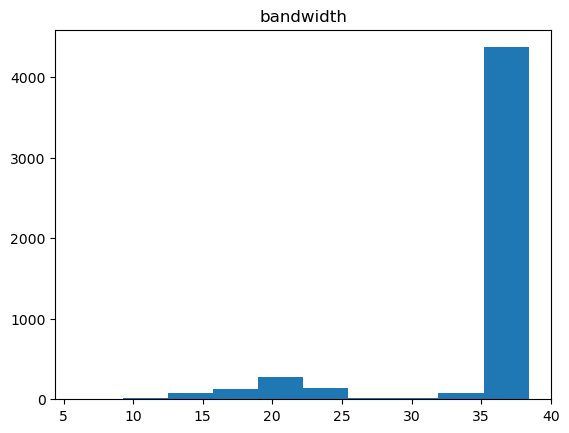

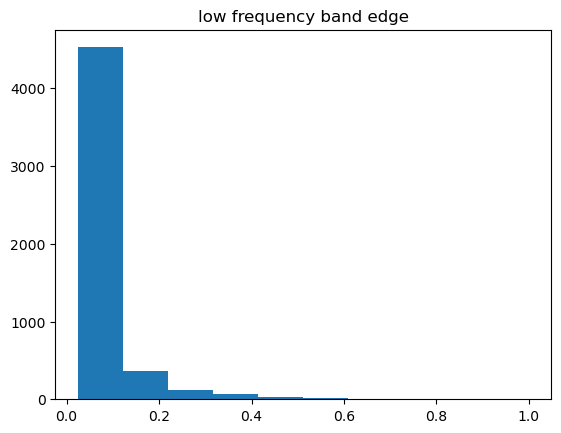

Text(0.5, 1.0, 'Envelope peak snr')

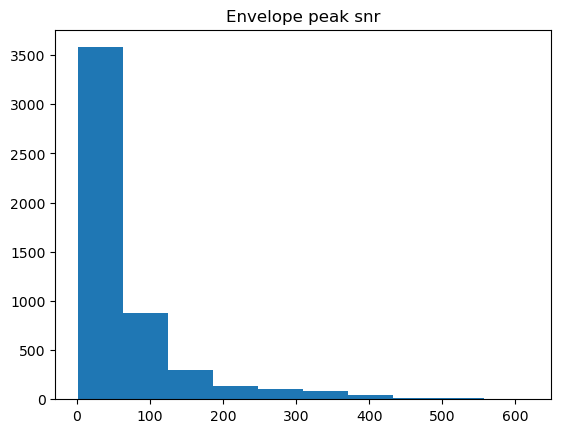

In [18]:
import matplotlib.pyplot as plt
plt.hist(bandwidth)
plt.title('bandwidth')
plt.show()
plt.hist(low_f_band_edge)
plt.title('low frequency band edge')
plt.show()
plt.hist(snr_filtered_peak)
plt.title('Envelope peak snr')